In [1]:
cat_set = "/content/cat"
dog_set = "/content/dog"

In [4]:
import os
import pandas as pd

# List the files in the directories
img_cat = [os.path.join(cat_set, file) for file in os.listdir(cat_set)[:1000]]
img_dog = [os.path.join(dog_set, file) for file in os.listdir(dog_set)[:1000]]

cat_df = pd.DataFrame({"image_path": img_cat, "Target": 1})
dog_df = pd.DataFrame({"image_path": img_dog, "Target": 0})
print(len(cat_df), len(dog_df))

1000 1000


In [5]:
# Concatenate the dataframes
cat_dog_df = pd.concat([cat_df, dog_df], ignore_index=True)

# Shuffle the combined dataframes
cat_dog_df = cat_dog_df.sample(frac=1).reset_index(drop=True)
cat_dog_df.head()

,image_path,Target
0,/content/dog/156.jpg,0
1,/content/cat/1981.jpg,1
2,/content/dog/926.jpg,0
3,/content/dog/906.jpg,0
4,/content/dog/801.jpg,0


In [21]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
from skimage.feature import hog

# Function to preprocess an image using HOG with fixed size
def preprocess_image_hog(image_path, target_size=(224, 224)):
    features_imag = []
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Read the image in grayscale
    if img is None:
        print(f"Error: Unable to read image at {image_path}")
        return None

    # Resize the image to the target size
    img_resized = cv2.resize(img, target_size)

    # Compute HOG features
    hog_features = hog(img_resized,
                       orientations=9,
                       pixels_per_cell=(8, 8),
                       cells_per_block=(2, 2),
                       block_norm='L2-Hys',
                       visualize=False)
    # Append the flattened image to the list
    features_imag.append(hog_features)
    return features_imag

In [22]:
# Create a new column to store HOG features
cat_dog_df['hog_features'] = None

# Apply HOG feature extraction to each image
for index, row in cat_dog_df.iterrows():
    image_path = row['image_path']
    hog_features = preprocess_image_hog(image_path)
    cat_dog_df.at[index, 'hog_features'] = hog_features

# Filter out rows with None values in the 'hog_features' column
filtered_cat_dog_df = cat_dog_df.dropna(subset=['hog_features'])

# Display the DataFrame with filtered HOG features
print(filtered_cat_dog_df.head())

              image_path  Target  \
0   /content/dog/156.jpg       0   
1  /content/cat/1981.jpg       1   
2   /content/dog/926.jpg       0   
3   /content/dog/906.jpg       0   
4   /content/dog/801.jpg       0   

                                        hog_features  
0  [[0.2089020928954427, 0.15767524129668228, 0.2...  
1  [[0.2064635882915747, 0.01884595056616435, 0.0...  
2  [[0.20060122308039116, 0.058233324778687756, 0...  
3  [[0.3544639339571799, 0.033879457968622954, 0....  
4  [[0.05530250688135867, 0.12694589903945827, 0....  


In [23]:
# Convert hog_features column to a numpy array
X = np.array(filtered_cat_dog_df['hog_features'].tolist())
y = filtered_cat_dog_df["Target"]

# Reshape X to a 2D array
X = X.reshape(X.shape[0], -1)

# Display the shape of X and y
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (2000, 26244)
y shape: (2000,)


In [24]:
from sklearn.preprocessing import StandardScaler
# Standardize the pixel values across all images
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

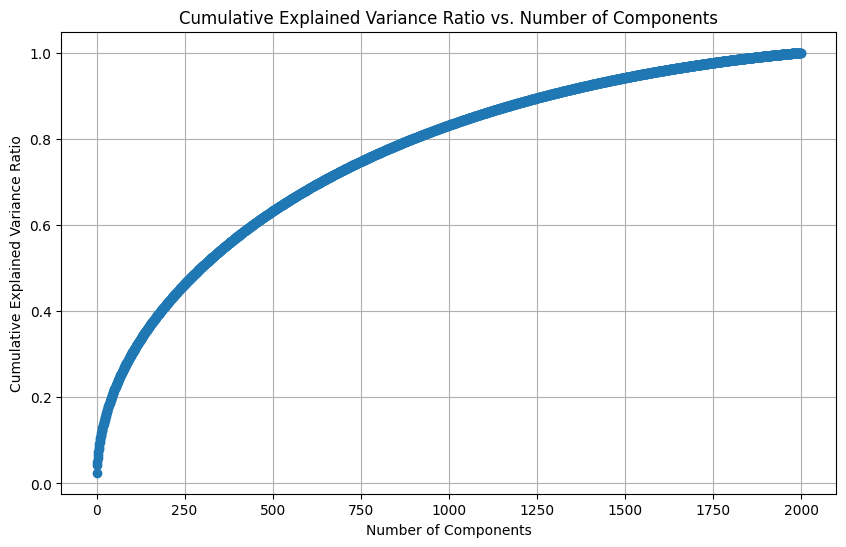

In [26]:
from sklearn.decomposition import PCA

# Perform PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Calculate explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Plot explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(explained_variance_ratio), marker='o', linestyle='-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance Ratio vs. Number of Components')
plt.grid(True)
plt.show()

In [27]:
from sklearn.pipeline import Pipeline

# Define the pipeline
scaler_pca_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Step 1: StandardScaler
    ('pca', PCA(n_components=0.95))  # Step 2: PCA with explained variance ratio
])

# Fit and transform the data using the pipeline
X_scaled_pca = scaler_pca_pipeline.fit_transform(X)

In [73]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled_pca, y, test_size=0.2, random_state=42)

NN

In [35]:
#!pip install torch torchvision torchaudio

In [74]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import torchvision
import torch.nn as nn

X_train_norm = torch.from_numpy(X_train).float()
y_train = pd.Series(y_train)
y_train = torch.from_numpy(y_train.values)

# Ensure X_train and y_train have the same number of rows
assert len(X_train_norm) == len(y_train), "Size mismatch between X_train and y_train"

# Create a tensor dataset
train_ds = TensorDataset(X_train_norm, y_train)

# Set random seed for reproducibility
torch.manual_seed(1)

# Define batch size
batch_size = 2

# Create DataLoader
train_dl = DataLoader(train_ds, batch_size, shuffle=True)

In [75]:
class Model(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.layer2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.layer1(x)
        x = torch.sigmoid(x)
        x = self.layer2(x)
        return x

input_size = X_train_norm.shape[1]
hidden_size = 16  # You can choose any suitable size
output_size = 1  # Assuming you're dealing with binary classification

# Create an instance of the model
model = Model(input_size, hidden_size, output_size)


In [76]:
# Define loss function (Binary Cross Entropy)
loss_fn = nn.BCEWithLogitsLoss()

# Define optimizer (e.g., Stochastic Gradient Descent)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

# Define the number of epochs
num_epochs = 20

# Training loop
for epoch in range(num_epochs):
    # Iterate over the batches
    for xb, yb in train_dl:
        # Forward pass
        pred = model(xb)
        yb = yb.view(-1, 1)
        # Calculate loss
        loss = loss_fn(pred, yb.float())  # Convert yb to float as BCEWithLogitsLoss expects float

        # Backward pass
        loss.backward()

        # Update model parameters
        optimizer.step()

        # Zero gradients
        optimizer.zero_grad()

    # Print the loss every epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')

Epoch [1/20], Loss: 0.6765199899673462
Epoch [2/20], Loss: 0.3672650456428528
Epoch [3/20], Loss: 0.9262349009513855
Epoch [4/20], Loss: 0.05733639746904373
Epoch [5/20], Loss: 0.008421767503023148
Epoch [6/20], Loss: 0.035411667078733444
Epoch [7/20], Loss: 0.009331390261650085
Epoch [8/20], Loss: 0.09472082555294037
Epoch [9/20], Loss: 0.023670610040426254
Epoch [10/20], Loss: 0.011240530759096146
Epoch [11/20], Loss: 0.012060497887432575
Epoch [12/20], Loss: 0.0214687529951334
Epoch [13/20], Loss: 0.0051505472511053085
Epoch [14/20], Loss: 0.004088802728801966
Epoch [15/20], Loss: 0.000483515061205253
Epoch [16/20], Loss: 0.011113281361758709
Epoch [17/20], Loss: 0.008972941897809505
Epoch [18/20], Loss: 0.008061965927481651
Epoch [19/20], Loss: 0.003170367795974016
Epoch [20/20], Loss: 0.01871490478515625


In [77]:
# Convert the normalized test data to a PyTorch tensor of type float
X_test_norm = torch.from_numpy(X_test).float()
# Convert the test labels to a PyTorch tensor
y_test = torch.from_numpy(y_test.values).long()  # Assuming y_test contains integer labels
# Make predictions on the normalized test data using the model
pred_test = model(X_test_norm)
# Determine the correct predictions by comparing predicted labels with actual labels
correct = (torch.argmax(pred_test, dim=1) == y_test).float()
# Calculate the accuracy by taking the mean of correct predictions
accuracy = correct.mean()
# Print the test accuracy
print(f'Test Acc.: {accuracy.item():.4f}')

Test Acc.: 0.5050
